In [1]:
pip install transformers datasets scikit-learn matplotlib seaborn torch


Columns: Index(['headline', 'clickbait'], dtype='object')
First few rows:
                                            headline  clickbait
0                                 Should I Get Bings          1
1      Which TV Female Friend Group Do You Belong In          1
2  The New "Star Wars: The Force Awakens" Trailer...          1
3  This Vine Of New York On "Celebrity Big Brothe...          1
4  A Couple Did A Stunning Photo Shoot With Their...          1


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated a

Epoch,Training Loss,Validation Loss
1,0.003400,0.058020
2,0.021200,0.047864


Evaluation Metrics:
Accuracy: 0.9897
Precision: 0.9900
Recall: 0.9894
F1 Score: 0.9897


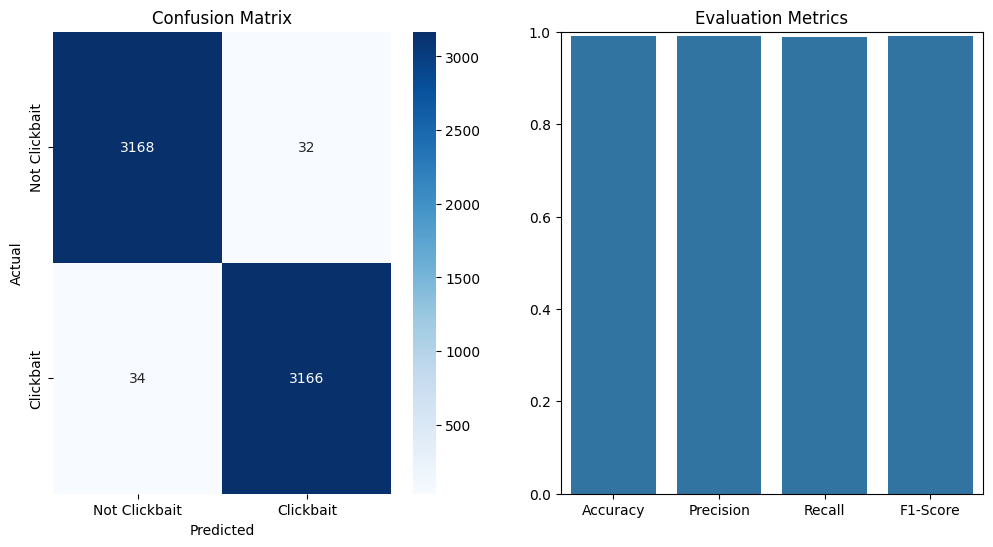

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset

def load_data(file_path):
    df = pd.read_csv(file_path)

    print("Columns:", df.columns)
    print("First few rows:")
    print(df.head())

    if df.isnull().values.any():
        print("Handling NaN values in dataset.")
        df = df.dropna(subset=['headline', 'clickbait'])  # Drop rows with NaN in 'headline' or 'clickbait'

    if len(df.columns) != 2:
        raise ValueError("Dataset does not have the expected number of columns")

    df.columns = ['title', 'label']

    df['label'] = df['label'].astype(int)

    return df

def prepare_data(df):
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    return train_df, test_df

def tokenize_data(df, tokenizer):
    return tokenizer(df['title'].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

def df_to_dataset(df, tokenizer):
    encodings = tokenize_data(df, tokenizer)
    dataset = Dataset.from_dict({
        'input_ids': encodings['input_ids'].tolist(),
        'attention_mask': encodings['attention_mask'].tolist(),
        'labels': df['label'].tolist()
    })
    return dataset

def load_model_and_tokenizer():
    model_name = 'distilbert-base-uncased'
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertForSequenceClassification.from_pretrained(model_name)
    return model, tokenizer

def train_model(train_dataset, eval_dataset, model, tokenizer):
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=2,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        no_cuda=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    trainer.train()
    return trainer

def evaluate_model(trainer, test_dataset):
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = np.array(test_dataset['labels'])

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    f1 = f1_score(labels, preds, average='binary')

    cm = confusion_matrix(labels, preds)

    # Print metrics
    print("Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1, cm

# Plot metrics
def plot_metrics(cm, accuracy, precision, recall, f1):
    plt.figure(figsize=(12, 6))

    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Clickbait', 'Clickbait'], yticklabels=['Not Clickbait', 'Clickbait'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Plot other metrics
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}
    plt.subplot(1, 2, 2)
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
    plt.title('Evaluation Metrics')
    plt.ylim(0, 1)

    plt.show()

def main():
    # Path to the dataset
    file_path = 'clickbait_data.csv'

    # Load and prepare data
    df = load_data(file_path)
    train_df, test_df = prepare_data(df)

    # Load tokenizer and model
    model, tokenizer = load_model_and_tokenizer()

    # Convert to Dataset
    train_dataset = df_to_dataset(train_df, tokenizer)
    test_dataset = df_to_dataset(test_df, tokenizer)

    # Train the model
    trainer = train_model(train_dataset, test_dataset, model, tokenizer)  # Ensure trainer is returned

    # Evaluate the model
    accuracy, precision, recall, f1, cm = evaluate_model(trainer, test_dataset)

    # Plot metrics
    plot_metrics(cm, accuracy, precision, recall, f1)

if __name__ == "__main__":
    main()
